COE731 - Sistemas dinâmicos e controle baseados em dados

# Aprendizado por reforço para controle de um levitador magnético

Gabriel Arruda Evangelista (gabrielevangelista7@poli.urfj.br)
***

## 1. Introdução

Controladores baseados em modelos necessitam de recalibrações ou reidenficiações com o tempo em função degradação do desempenho de componentes das plantas ou mudança do ponto de operação. Isso pode implicar necessidade de paradas de plantas ou processos de manutenção custos. Spielberg et al. propõe um método [1] baseado em aprendizado por reforço que apresenta a vantagem de ser baseado em dados e poder reajustar sua política de controle a partir da iteração com o próprio sistema em tempo real de maneira adaptativa. Dally e Van Kampen apresentam [2] processo análogo a partir de algoritmo de aprendizado similar para emprego em um controlador de voo, no entanto, estes estudam as vantagens em termos de robustez em função da mudança da planta e tolerância a diferentes tipos de falhas de componentes. Michele et al. também aplicam técnica similar para estabilização e controle de um processo caótico e não linear governado pela equação de Kuramoto-Sivashinsky [3] indicando bons resultados em levar o sistema para uma condição de equilíbrio originalmente instável de forma robusta às condições iniciais.

O presente trabalho parte da técnica apresentada em [1] que é aplicada a um levitador magnético [4]. O problema já foi endereçado por uma abordagem de Model Predictive Control (MPC) anteriormente [5] mas também apresenta resultados, em geral satisfatórios para soluções simples como PID com observador implementado a partir de sua linearização. No entanto, é uma planta de caracterísitacas instáveis e não linearidades diferentes das anteriormente resolvidas com a técnica em estudo. Assim, o presente trabalho busca analisar o comportamento da técnica frente a um problema de controle com estas características.

Inicialmente é apresentado o modelo matemático da planta estudada e em seguida é feita uma rápida revisão dos algoritmos e conceitos empregados ao longo da seção 2. Na seção seguinte são apresentados os código relativos a modelagem e solução do problema. Na quarta parte são apresentados os resultados obtidos com o sistema analisado e também uma reprodução do artigo original [1]. Por fim, são apresentadas as conclusões à luz do apresentado.



## 2. Modelo Matemático
### 2.1 O levitador magnético
O trabalho apresentado busca analisar o controle de um levitador magnético educacional apresentado em [4].


A dinâmica vertical é descrita por:
$$
m\frac{d^2h}{dt^2} = mg - K\frac{i^2}{h^2}
$$

A leitura do sensor de posição $y$ se dá por $ y = \gamma h + y_0 $, onde $\gamma$ é um ganho positivo e $y_0$ um ajuste linear de forma queo $ y \in (-2V, 2V)$. 
A corrente de controle $i$ é controlada pelo variável de controle u pela realação linear: $ i = \rho u + i_0 $. A variável de controle apresenta uma faixa de operação $ u \in (-3V, 5V) $.
Ao incorporar isto à equação dinâmica tem-se que[2]:
$$
m \frac{d^2 y}{dt^2} = \gamma m g - \frac{K(\rho u + i_0)^2\gamma^3}{(y - y_0)^2}
$$
Ou, na realização por espaço de estados, com $x = [y, \frac{dy}{dt}]^T$:
$$\dot{x_1} = x_2 $$

$$ \dot{x_2} =  \gamma g - \frac{K(\rho u + i_0)^2\gamma^3}{m(y - y_0)^2} $$

O sistema é não linear e instável devido ao termo constante na equação de $\dot{x_2}$, como era de se esperar pela configuração do sistema.

### 2.2 Aprendizado por Reforço
O aprendizado por reforço consiste nas técnicas que visam a generalização a partir da interação com o ambiente, ou seja, como mapear açoes frente a cada estado de um sistema para maximizar um resultado sinal de recompensa [8]. Tal processo pode ser particularmente interessante para maximizar uma sequência de recompensas, e não somente a recompensa da ação presente. Nessa dinâmica não é apresentado para o agente quais ações se deve tomar mas este busca aprender pela interação com o ambiente [9].

A configuração padrão do aprendizado por reforço consiste em um agente, interagindo com um ambiente *E* em uma sequência discreta de passos de tempo *t*. A cada passo, o agente percebe uma observação ($x_t$) do estado ($s_t$) do ambiente, realiza uma ação $a_t$ e em função dessa o ambiente retribui com uma recompensa $r_t$ e evolui para um novo estado. O comportamento do agente, ou seja, como o estado é mapeado no espaço de ações, é chamado de politica $\pi$. O retorno esperado de um estado é a soma descontada de todas as recompensas futuras esperadas, $ R_t = \sum_{i=t}^{T}{\gamma^{(i-t)}r(s_i, a_i)} $ onde $ \gamma \in [0,1] $ é o fator de desconto e corresponde implicitamente ao valor dado as recompensas futuras.

A função Q, que estima o retorno esperado do para a partir de um dado estado $ s_t $ é usualmente empregada para formulação das políticas. Esta pode ser definida de maneira recursiva pela Equação de Bellman:

$$
 Q^\mu(s_t, a_t) =  \mathbb{E}_{r_t, s_{t+1}\sim E}[r(s_t, a_t) + \gamma Q^\mu(s_{t+1}, \mu(s_{t+1}))]
 $$

Para uma política determinística é usual se implementar $\mu = argmax_aQ(s_t, a_t)$.

Desta forma o sucesso do método de aprendizado de reforço está associado a estimativa da função Q. Está é feita por um modelo de parâmetros $ \theta $. Quando o modelo utilizado se vale de técnicas de aprendizado profundo diz-se que é algoritmo de Aprendizado por Reforço Profundo (DRL, do inglês "*Deep Reinforcement Learning*"). A perda quadrática do estimador  para os parâmetros $ \theta $ é dada por:

$$
L(\theta^Q) = \mathbb{E} [(r + \gamma \arg\max_aQ(s_{t+1}, a_{t+1})|\theta -  Q(s_{t}, a_{t})|\theta )^2]
$$

Neste caso tanto o estimador avaliado, quando o alvo analisado por esta relação de perda recorrem a mesma função Q. E esta relação circular acaba prejudicando o processo de aprendizado e tornando-o instável.


### 2.2.1 DQN

Mnih et al. apresentaram [7] inovações no sentido de estabilizar e tornar mais eficiente o processo descrito na seção anterior de maneira a obter resultados com agentes que apresentavam pontução acima do nível de humanos em jogos de Atari. O algoritmo proposto, nomeado de *"Deep Q Network"* (DQN), emprega redes convolucionais para estimativa da função Q, permitindo que os estados fossem as telas dos jogos. Adicionalmente o algoritmo inovou ao empregar uma rede alvo e o *"Replay Memory"* (RM).
A rede alvo consiste em uma rede de mesmos hiperparâmetros que a empregada para função Q e é usada para quebrar a cicularidade da equação de perda modificando-a para:
	$$ 	L(\theta^Q) = \mathbb{E} [(r + \gamma \arg\max_aQ(s_{t+1}, a_{t+1}|\theta') -  Q(s_{t}, a_{t}|\theta) )^2]  $$

A quebra desta circularidade permite ganhos de estabilidade no aprendizado ao fixar temporariamente o alvo da função de perda. Esta rede é periodicamente atulizada com uma cópia dos pesos da rede na qual é efetuado o aprendizado.

O RM por sua vez armazena uma grande quantidade de transições e permite que o processo de aprendizado realize amostras em bateladas aleatórias para realizar o processo de aprendizado. Este processo apresenta vantagens pois cada transição é potencialmente utilizada na atualizaçã de múltiplos pesos e reduz-se a correlação, uma vez que as amostras deixam consecutivas, de forma a promover a redução da variância dos pesos na evolução do aprendizado.

O emprego destes dois conceitos no algoritmo permitiu maior estabilidade no aprendizado em relação a algoritmos anteriores e permitiu avanços no campo de aprendizado por reforço.


### 2.2.2 DDPG

O algoritmo *Deep Deterministic Policy Gradient* (DDPG) [6] usa conceitos que partem do DQN porém com uma arquitetura Ator Crítico. Esta arquitetura prevê uma rede Crítica para estimativa das funções Q e uma rede diferente para implementação da política. Outra diferença é a normalização dos valores em cada batelada.

A atualização da rede crítica é dada de maneira similar ao processo do DQN, no entanto, a atualização de sua rede alvo é dada de maneira contínua e linear mas com uma inércia de maneira que:
$$ \theta_{tgt} \leftarrow \tau\theta + (1 - \tau)\theta_{tgt} \text{, sendo } \tau << 1 $$

 A rede atora tem seus parâmetros atualizados por pelo gradiente descendente do J a partir dos valores de Q de maneira que:
		$$
		\nabla_{\theta^\mu} \approx \mathbb{E}[\nabla_aQ(s,a|\theta^Q)|_{s_t, a=\mu(s_t)}\nabla{\theta^\mu}\mu(s|\theta^\mu)|s_t]
		$$

O fato da ação ser diretamente implementada pela saída de uma rede permite que sua saída seja livre e de acordo com a função de ativação da camada de saída. Assim, sua saída é contínua e permite aplicações em  classes de problemas diferentes do que a DQN.



### 2.2.3 DRL aplicado a controle
Para a abordagem de problemas de controle com emprego de DRL, [1] propõe uma variante do algoritmo Deep Deterministic Policy Gradient (DDPG) [5] e estrutura correspondências entre a teoria de controle e os componentes do aprendizado por reforço.
Este algoritmo também apresenta as características de redes alvo e buffer de memória, antes apresentados por Mnih et al. [6], para estabilização e melhoria do processo de aprendizado. No entanto, o algoritmo diverge principalmente no emprego do *"gradient cliping"* [7] para adequar as saídas da rede responsável pela política aos limites das faixas de valores das variáveis de controle mantendo o processo de aprendizado. Outra adição é a inclusão da referência para para no contexto do aprendizado por reforço.




## 3. Solução
Para solução foi empregada a biblioteca GYM para uso de seu *framework* de aprendizado por reforço através da implementação de seus objetos virtuais. Para realização das redes neurais foi utilizada a biblioteca pytorch que já fornece as interfaces necessárias e permite o processamento com o uso de uma GPU gerando ganhos em termos de tempo de processamento. A célula abaixo contém os comandos para instalação destas bibliotecas (comentados) e também as demais importações de bibliotecas utilizadas. Além disso é feita a con
uração do dispositivo no qual serão processadas algumas operações quando indicado (CPU ou GPU, caso disponível). Também são criados diretórios para armazenar os modelos das redes e resultados.

In [1]:
# if necessary uncomment and run to install these libraries. Those are already installed by default in Google Colab.
# Colab seed function does not work very accurately due to implementation of dynamical hardware allocation system (https://discuss.pytorch.org/t/unable-to-reproduce-results-using-pytorch-in-colab/85247, I do not understand exactly way) so the training process output may have some differences. The presented results was obtained on my PC using PyCharm Jupyter editor.


# ! pip install gym
# ! pip install numpy
# ! pip3 install torch==1.10.2

In [26]:

import random
import matplotlib.pyplot as plt
from gym import Env, spaces
import numpy as np
from typing import Optional
import joblib
import os
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
plt.rcParams['axes.grid'] = True

device = "cuda" if t.cuda.is_available() else "cpu"

if not os.path.exists('models'):
    os.mkdir('models')
if not os.path.exists('results'):
    os.mkdir('results')

s = 42
random.seed(s)
np.random.seed(s)
t.random.manual_seed(s)

Para solução do problema de controle foi implementado o algoritmo DDPG [6]. Foram utilizadas de referência para a implementação [10] e [11]. A arquitetura da rede neural do ator foi modificada na camada de saída de forma que a faixa de valores possíveis passasse a coincidir com a faixa de valores possíveis da variável de controle. Foi utilizada a tangente hiperbólica e uma transformação linear para esta adequação, isto difere do proposto por [1] que usa o método de *"gradient clipping"*[7] para tal função. As redes neurais correspondentes ao estimador do ator e do crítico apresentam arquiteturas diferentes e foram implementadas em duas diferentes classes. As redes são implementadas a partir do módulo "nn" (*neural network*) do pytorch. Destaca-se a função de saída da *ActorNetwork* que implementa a conformação da saída ao problema tratado.

A implementação é apresentada na célula abaixo:

In [27]:
# implementation of DDPG critic network as in [6]
class CriticNetwork(nn.Module):
    def __init__(self, obs_shape, n_action,
                 lr=1e-3, fc1dim=400, fc2dim=300,
                 weight_decay=1e-1, device='cpu',
                 filename='test', checkpoint_dir='models/'):
        super(CriticNetwork, self).__init__()

        self.obs_shape = obs_shape
        self.n_action = n_action

        # directory to store the learning result models
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, filename)

        # Normalization layers
        self.bn1 = nn.LayerNorm(fc1dim)
        self.bn2 = nn.LayerNorm(fc2dim)

        # Fully connected layers values initialization as in [6]
        self.fc1 = nn.Linear(*obs_shape, fc1dim)
        f_in = float(1/np.sqrt(np.prod(obs_shape)))
        self.fc1.weight.data.uniform_(-f_in, f_in)
        self.fc1.bias.data.uniform_(f_in, f_in)
        self.bn1 = nn.LayerNorm(fc1dim)

        self.fc2 = nn.Linear(fc1dim, fc2dim)
        f_in2 = float(1/np.sqrt(fc1dim))
        self.fc2.weight.data.uniform_(-f_in2, f_in2)
        self.fc2.bias.data.uniform_(-f_in2, f_in2)
        self.bn2 = nn.LayerNorm(fc2dim)

        self.q_layer = nn.Linear(fc2dim, 1)
        self.q_layer.weight.data.uniform_(-3e-3, 3e-3)
        self.q_layer.bias.data.uniform_(-3e-3, 3e-3)

        self.a_layer = nn.Linear(n_action, fc2dim)
        self.a_layer.weight.data.uniform_(-3e-3, 3e-3)
        self.a_layer.bias.data.uniform_(-3e-3, 3e-3)

        # Optimizers parameter weight_decay -> l2 normalization for learning process
        self.optimizer = optim.Adam(params=self.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.to(device)

    def forward(self, state, action):
        # forward propagation function of NN
        state_value = self.fc1(state)
        state_value = f.relu(self.bn1(state_value))

        state_value = self.fc2(state_value)
        state_value = f.relu(self.bn2(state_value))

        action_value = self.a_layer(action)

        state_action_value = f.relu(action_value + state_value)
        q = self.q_layer(state_action_value)

        return q

    def save_checkpoint(self):
        t.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(t.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        t.save(self.state_dict(), checkpoint_file)

# implementation of DDPG actor network as in [6], analogous to Critic but with different layers
class ActorNetwork(nn.Module):
    def __init__(self, obs_shape, n_action,
                 lr=1e-3, fc1dim=400, fc2dim=300,
                 device='cpu',
                 filename='test', checkpoint_dir='models/'):
        super(ActorNetwork, self).__init__()

        self.obs_shape = obs_shape
        self.n_action = n_action

        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, filename)

        self.fc1 = nn.Linear(*obs_shape, fc1dim)
        f_in = float(1/np.sqrt(np.prod(obs_shape)))
        self.fc1.weight.data.uniform_(-f_in, f_in)
        self.fc1.bias.data.uniform_(f_in, f_in)
        self.bn1 = nn.LayerNorm(fc1dim)

        self.fc2 = nn.Linear(fc1dim, fc2dim)
        f_in2 = float(1/np.sqrt(fc1dim))
        self.fc2.weight.data.uniform_(-f_in2, f_in2)
        self.fc2.bias.data.uniform_(-f_in2, f_in2)
        self.bn2 = nn.LayerNorm(fc2dim)

        self.mu = nn.Linear(fc2dim, n_action)
        self.mu.weight.data.uniform_(-3e-3, 3e-3)
        self.mu.bias.data.uniform_(-3e-3, 3e-3)

        self.optimizer = optim.Adam(params=self.parameters(), lr=lr)
        self.device = device
        self.to(device)

    def forward(self, state):
        x = self.fc1(state)
        x = f.relu(self.bn1(x))

        x = self.fc2(x)
        x = f.relu(self.bn2(x))

        x = self.mu(x)

        # modification of output layer to fit the control variable function
        actions = 4 * t.tanh(x) + 1
        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        t.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(t.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        t.save(self.state_dict(), checkpoint_file)



A célula abaixo implementa as funções auxiliares necessárias para o agente.
O processo de Ornstein Uhlenbeck é um método matemático estocástico para geração de um movimento browniano. Este processo é usado originalmente [6] para gerar as divergências nas açoes do agente de forma a promover a exploração.
O replay buffer [7] é implementado com uma pre-alocação de memória para armazenar as transições do agente e depois ser amostrado no seu processo de aprendizado.

In [28]:

class OrnsteinUhlenbeckNoise:
    # https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.x0 = x0
        self.reset()

    def reset(self):
        self.x_t = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __call__(self):
        x_next = self.x_t + \
                 self.theta * (self.mu - self.x_t) * self.dt + \
                 self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)

        self.x_t = x_next
        return x_next


class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        self.max_size = max_size

        self.state_memory = np.zeros((self.max_size, *state_shape))
        self.action_memory = np.zeros((self.max_size, n_actions))
        self.next_state_memory = np.zeros((self.max_size, *state_shape))
        self.reward_memory = np.zeros(self.max_size)
        self.done_memory = np.zeros(self.max_size, dtype=np.bool)

        self.ptr = 0

    def update_pointer(self):
        self.ptr += 1

    def store_transition(self, state, action, next_state, reward, done):
        idx = self.ptr % self.max_size

        self.state_memory[idx] = state
        self.action_memory[idx] = action
        self.next_state_memory[idx] = next_state
        self.reward_memory[idx] = reward
        self.done_memory[idx] = done

        self.update_pointer()

    def sample_memory(self, batch_size):
        max_idx = min(self.ptr, self.max_size)
        if batch_size > max_idx:
            raise "Sample size is too big"

        indexes = np.random.choice(max_idx, batch_size, replace=False)

        state_sample = self.state_memory[indexes]
        action_sample = self.action_memory[indexes]
        next_state_sample = self.next_state_memory[indexes]
        reward_sample = self.reward_memory[indexes]
        done_sample = self.done_memory[indexes]

        return state_sample, action_sample, next_state_sample, reward_sample, done_sample

A classe que implementa o agente é apresentada a seguir.

In [29]:

class DDPGAgent:
    def __init__(self, obs_shape, n_action,
                 lr_actor=1e-4, lr_critic=1e-3,
                 tau=1e-3, gamma=.99,
                 replay_buffer_size=1e6, batch_size=64,
                 uo_theta=.15, uo_sigma=.2,
                 device='cpu', fc1dim=400, fc2dim=300,
                 critic_l2=1e-2):

        self.obs_shape = obs_shape
        self.n_action = n_action
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.tau = tau
        self.gamma = gamma
        self.device = device
        self.batch_size = batch_size

        self.std_uo_sigma = uo_sigma
        self.std_uo_theta = uo_theta

        self.memory = ReplayBuffer(max_size=int(replay_buffer_size),
                                   state_shape=[obs_shape],
                                   n_actions=n_action)

        self.noise = OrnsteinUhlenbeckNoise(mu=np.zeros(n_action),
                                            sigma=uo_sigma, theta=uo_theta)

        self.actor_net = ActorNetwork(obs_shape=[obs_shape], n_action=n_action, lr=lr_actor,
                                      fc1dim=fc1dim, fc2dim=fc2dim, device=device, filename='actor_ddpg')

        self.critic_net = CriticNetwork(obs_shape=[obs_shape], n_action=n_action, lr=lr_critic,
                                        fc1dim=fc1dim, fc2dim=fc2dim, device=device, 
                                        weight_decay=critic_l2, filename='critic_ddpg')

        self.actor_net_target = ActorNetwork(obs_shape=[obs_shape], n_action=n_action, lr=lr_actor,
                                             fc1dim=fc1dim, fc2dim=fc2dim, device=device, filename='actor_tgt_ddpg')

        self.critic_net_target = CriticNetwork(obs_shape=[obs_shape], n_action=n_action, lr=lr_critic,
                                               fc1dim=fc1dim, fc2dim=fc2dim, device=device, 
                                               weight_decay=critic_l2, filename='critic_tgt_ddpg')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor_net.eval()
        state = t.tensor(observation, dtype=t.float, device=self.actor_net.device)

        # get a continuous action summed by OU noise to promote exploration
        action = self.actor_net.forward(state) + t.tensor(self.noise(), dtype=t.float, device=self.actor_net.device)
        self.actor_net.train()
        # returning a value on CPU apart from the original graph
        return action.cpu().detach().numpy()
    
    # interfaces for memory buffer functionality
    def store_transition(self, state, action, next_state, reward, done):
        self.memory.store_transition(state, action, next_state, reward, done)

    def sample_memory(self):
        states, actions, states_, rewards, dones = self.memory.sample_memory(self.batch_size)

        states = t.tensor(states, device=self.device, dtype=t.float)
        actions = t.tensor(actions, device=self.device, dtype=t.float)
        rewards = t.tensor(rewards, device=self.device, dtype=t.float)
        states_ = t.tensor(states_, device=self.device, dtype=t.float)
        dones = t.tensor(dones, device=self.device, dtype=t.bool)

        return states, actions, states_, rewards, dones
    
    # save/load network parameters to a file
    # in the end of trainning the best model will be there.
    def save_checkpoints(self):
        self.critic_net.save_checkpoint()
        self.critic_net_target.save_checkpoint()
        self.actor_net.save_checkpoint()
        self.actor_net_target.save_checkpoint()

    def load_checkpoint(self):
        self.critic_net.load_checkpoint()
        self.critic_net_target.load_checkpoint()
        self.actor_net.load_checkpoint()
        self.actor_net_target.load_checkpoint()

    def learn(self):
        # the agent waits the buffer reach a minimum experience to begin the learning process.
        # Before that the function skip before execution
        if self.memory.ptr < self.batch_size:
            print('skipping learning, not enough transitions...')
            return

        # sample multiple transitions for parallel processing
        states, actions, next_states, rewards, dones = self.sample_memory()

        # use the target actor and target critic networks
        # to get the estimation of future values to be used in loss function (q_pred)
        tgt_actions = self.actor_net_target.forward(state=next_states)
        q_next_tgt = self.critic_net_target.forward(state=next_states, action=tgt_actions)

        # treat final values
        q_next_tgt[dones] = 0.0

        q_tgt = rewards + self.gamma * q_next_tgt.view(-1)
        q_tgt = q_tgt.view(self.batch_size, 1)

        q_pred = self.critic_net.forward(states, actions)

        # Q network with mean squared error
        self.critic_net.optimizer.zero_grad()
        critic_loss = f.mse_loss(input=q_tgt, target=q_pred).to(self.critic_net.device)
        critic_loss.backward()
        self.critic_net.optimizer.step()

        # pi network with mean of gradient
        self.actor_net.optimizer.zero_grad()
        actor_loss = t.mean(-self.critic_net.forward(states, self.actor_net.forward(states)))
        actor_loss.backward()
        self.actor_net.optimizer.step()

        self.update_network_parameters(self.tau)

    def update_network_parameters(self, tau):
        actor_params = self.actor_net.state_dict()
        critic_params = self.critic_net.state_dict()
        tgt_actor_params = self.actor_net_target.state_dict()
        tgt_critic_params = self.critic_net_target.state_dict()

        # linear update with inertia
        for key in tgt_actor_params.keys():
            tgt_actor_params[key] = tau * actor_params[key].clone() + (1 - tau) * tgt_actor_params[key].clone()

        for key in tgt_critic_params.keys():
            tgt_critic_params[key] = tau * critic_params[key].clone() + (1 - tau) * tgt_critic_params[key].clone()

        self.actor_net_target.load_state_dict(tgt_actor_params)
        self.critic_net_target.load_state_dict(tgt_critic_params)

    # adaptation like in Spielberg work
    def learning_update(self, state, tol):
        set_point = state[0]        # the first state position is dedicated for reference_t
        memory = state[2:]          # state[2:] -> y_t to t_{t-memory_len}
        last_states_into_tol = (np.abs(memory - set_point) < tol).all()
        if last_states_into_tol:
            self.noise.sigma = 0
            self.noise.theta = 0
        else:
            self.noise.sigma = self.std_uo_sigma
            self.noise.theta = self.std_uo_theta




Na célula de código a seguir a classe Maglev implementa uma sublasse concreta da classe abstrada Env do GYM. 
Esta modela o levitador magnético como um Enviroment do RL.

In [30]:

class Maglev(Env):
    # implementation based on Cartpole version on GYM documentation
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
    def __init__(self):
        # Parameters from: Fama, Régis Campos, et al.
        # "Predictive control of a magnetic levitation system with explicit treatment of operational constraints."
        # Proceedings of the 18th International Congress of Mechanical Engineering, Ouro Preto, Brazil. 2005.
        self.m = 2.12e-2
        self.g = 9.8
        self.y0 = -7.47
        self.gamma = 328
        self.i0 = .514
        self.rho = .166
        self.K = 1.2e-4

        self.y_threshold = 2
        self.dy_threshold = 50

        self.time_step = 0.005
        self.u_upper_threshold = 5
        self.u_lower_threshold = -3
        
        # delta_u_limit from fig. 4 of [4]
        self.delta_u_limit = 3 / self.time_step  

        self.max_steps = 1 / self.time_step

        # state with memory implementation like in Spielberg reference
        self.n_memory = 0

        # setup for gym environment framework
        high_act = np.array(
            [self.delta_u_limit]
        )
        high_obs = np.array(
            [
                self.y_threshold * 2,   # ref
                self.dy_threshold * 2,  # dy
                self.y_threshold * 2,   # y
                self.u_upper_threshold
            ] + self.n_memory * [
                self.y_threshold * 2,   # y_memory
            ],
            dtype=np.float32
        )

        low_obs = -high_obs
        low_obs[3] = self.u_lower_threshold

        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
        self.observation_space = spaces.Box(low_obs, high_obs, dtype=np.float32)

        # variables initialization
        self.state = None
        self.previous_u = None
        self.step_counter = None
        
        # this variable will be functions to be set with config functions
        # self.reference_function(t) -> ref
        # self.reward_function(state, action, ref) -> reward 
        # (for this work state[0] = (y_t - ref) so i will not use reference, but could be usefull as a pattern
        self.reference_function = None
        self.reward_function = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        assert self.reference_function is not None, "Define a reference function with config_reference method"
        assert self.reward_function is not None, "Define a reward function with config_reward method"

        # translate
        _, y_dot, y, u, *memory = self.state

        # u update
        u = self.previous_u + action * self.delta_u_limit
        u = np.clip(u, a_min=-3, a_max=5)

        # dynamic equation
        y_ddot = self.gamma * self.g - \
                 self.K * (self.rho * u + self.i0) ** 2 * self.gamma ** 3 / \
                 self.m / ((y - self.y0) ** 2)

        # memory shift
        if self.n_memory > 0:
            memory = [y] + memory[:-1]

        # euler integration
        y = y + self.time_step * y_dot
        y_dot = y_dot + self.time_step * y_ddot

        # get error
        ref = self.reference_function(self.step_counter * self.time_step)
        err = y - ref

        # save state internally
        self.state = err, y_dot, y, u, *memory

        # stopping condition
        terminated = bool(
            np.abs(y) > self.y_threshold
            or np.abs(y_dot) > self.dy_threshold
            or self.step_counter >= self.max_steps
        )

        # reward function
        if not terminated:
            reward = self.reward_function(self.state, action, ref)
        else:
            reward = 0

        self.step_counter += 1
        self.previous_u = u

        return np.array(self.state, dtype=np.float32).squeeze(), reward, terminated, {}

    def reset(self, *,
              seed: Optional[int] = None,
              x0_variance: Optional[float] = 0):
        self.state = (
            self.reference_function(0),
            np.random.uniform(low=-x0_variance * self.dy_threshold, high=x0_variance * self.dy_threshold),
            np.random.uniform(low=-x0_variance * self.y_threshold, high=x0_variance * self.y_threshold),
            0,
            *(self.n_memory * [0]))
        self.previous_u = 0
        self.step_counter = 0

        return np.array(self.state, dtype=np.float32)

    def render(self, mode=None):
        pass

    def config_reference(self, func):
        self.reference_function = func

    def config_reward(self, func):
        self.reward_function = func


A célula a seguir é uma biblioteca de funções que serão utilizadas para configurar o ambiente e impor as referências.
A função original apresentada em [1] é implementada, no entanto ela não funciona para o problema analisado. Isto se dá pelo fato do sistema ser instável então se a função de recompensa for somente punitiva, o agente tende a buscar políticas que impliquem o menor número de passos possível, ou seja, ele passa a tomar ações instabilizantes para encer o episódio o quanto antes.
Para solucionar este problema foram implementadas funções de recompensas que apresentem valores sempre positivos, porém que tendam a zero com o aumento do erro.
Foram implementadas 3 versões de funções de recompensas desta maneira. A primeira com um formato análogo ao de uma gaussiana centrada em zero. A segunda é descontínua, em que o centro da faixa de valores é corresponde a um patamar constante e as exremidades correspondem as extremidades da gaussina multiplicada por um fator de redução. E a terceira função é similar a primeira mas tenta incorporar a ideia de um controle ótimo punindo o uso de ações de controle, com um termo negativo de $\Delta u^2$. Os parâmetros foram resultados de processo de tentativas e erro.
Em seguida são implementadas uma função de referência com 3 degraus em 3 instantes de tempo diferentes e uma função que retorna uma função de referencia constante com o nível defindo pelo parâmetro de entrada função geradora.

In [31]:
# original function from [1]
def neg_abs_err_rwd(state, action, ref):
    err = state[0]
    return - np.abs(err)

# reward functions used
# reward function 1
def exponential_deviation_rwd(state, action, ref):
    err = state[0]
    return np.exp(-err**2/0.05)


# reward function 2
def optim_exp_dev_rwd(state, action, ref):
    err = state[0]
    rwd = np.exp(-err**2/0.05)
    rwd -= 0.25 * action**2
    return rwd


# rwd function evaluation only
def quadratic_err(state, action, ref):
    err = state[0]
    return err**2

# function that return a reference function with a const step at some specified level
def generate_const_ref_func(r):
    def const_ref(t):
        return r

    return const_ref

# reference function with 3 steps at different (hardcoded) levels and times
def multi_step_ref_func(t):
    if t < .3:
        return 5
    elif t < .6:
        return 9
    else:
        return 11


A seguir é implementada uma classe que promove o treinamento do agente no ambiente definido e salva o melhor modelo e o resultado em arquivos de nome especificado. Para isso são realizados um número de episódios definido pelo parâmetro n_episodes. Adicionalmente também é plotada a curva de aprendizado do trainamento.

In [32]:
class Coach:
    def __init__(self, env, agent, n_episodes, train_limit, filename):
        self.env = env
        self.agent = agent
        self.n_episodes = n_episodes
        self.filename = filename
        self.train_limit = train_limit

        agent.actor_net.checkpoint_file = 'models/' + filename + 'actor' 
        agent.actor_net_target.checkpoint_file = 'models/' + filename + 'actor_tgt'
        agent.critic_net.checkpoint_file = 'models/' + filename + 'critic'
        agent.critic_net_target.checkpoint_file = 'models/' + filename + 'critic_tgt'

    def train(self):
        best_score = self.env.reward_range[0]
        score_history = []

        # run n_episodes
        for i in range(self.n_episodes):
            # reset the enviroment, done variable, score, and noise
            obs = self.env.reset(x0_variance=0.0)
            done = False
            score = 0
            self.agent.noise.reset()

            # define the level of step at the beginning of each episode and set the const ref function with generator function
            # the training will be done with steps in uniformly sampled levels
            r = np.random.uniform(self.train_limit[0], self.train_limit[1])
            self.env.config_reference(generate_const_ref_func(r))

            # run the episode. done variable finnish it, the reward of each step is summed in score
            while not done:
                action = self.agent.choose_action(obs)
                next_obs, reward, done, _ = self.env.step(action)
                self.agent.store_transition(obs, action, next_obs, reward, done)
                self.agent.learning_update(next_obs, 0.01)
                self.agent.learn()
                score += reward
                obs = next_obs

            # at the end of each episode the total score is registered
            score_history.append(score)
            # the moving average of 100 episodes is used to compare the models
            avg_score = np.mean(score_history[-100:])

            # if the moving avg is the best save the model into a file
            if avg_score > best_score:
                best_score = avg_score
                self.agent.save_checkpoints()
            print('episode ', i, 'score %.1f' % score,
                  'average score %.1f' % avg_score)

        # get the best model from file
        self.agent.load_checkpoint()

        # store the learning function on a file
        result = {
            'score_history': score_history,
            'best_score': best_score
        }
        joblib.dump(result, 'results/'+self.filename+'_learning')

        x = [i + 1 for i in range(self.n_episodes)]
        running_avg = np.zeros(len(score_history))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(score_history[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
        plt.show()



Nas próxima célula os ambientes e agentes são inicializados e é realizado o treinamento. Os parâmetros usados nos agentes são apresentados na sua inicialização. Suas execuções demoram alguns minutos. São testadas duas diferentes funções de recompensa.
A primeira função de recompensa testada é:
$$
rwd = \exp\left(-\frac{e^2}{0.05}\right)
$$

C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
... saving checkpoint ...
... saving checkpoint ...
episode  0 score 0.5 average score 0.5
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
episode  1 score 0.0 average score 0.3
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
... saving checkpoint ...
... saving checkpoint ...
episode  2 score 2.4 average score 1.0
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
episode  3 score 0.3 average score 0.8
skipping learning, n

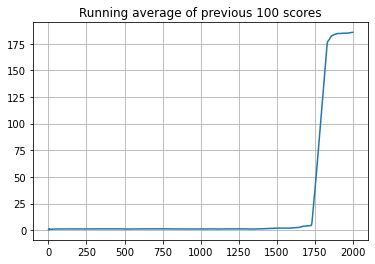

In [33]:
n_episodes = 2000
env_rwd_1 = Maglev()
env_rwd_1.config_reward(exponential_deviation_rwd)
env_rwd_1.config_reference(generate_const_ref_func(0))

agent_1 = DDPGAgent(obs_shape=env_rwd_1.observation_space.shape[0],
                  n_action=env_rwd_1.action_space.shape[0],
                  lr_actor=1e-4, lr_critic=1e-3,
                  tau=1e-3, gamma=.99,
                  replay_buffer_size=5e4, batch_size=256,
                  uo_theta=.15, uo_sigma=.05,
                  device=device, fc1dim=400, fc2dim=300,
                  critic_l2=1e-4)

coach_1 = Coach(env=env_rwd_1, agent=agent_1, n_episodes=n_episodes, train_limit=(-.5, .5) ,filename='exponential_deviation_rwd')
coach_1.train()


A segunda função de recompensa tenta incorporar a mesma ideia do controle ótimo atribuindo um custo as ações de controle na tentativa de melhorar comportamentos osciliatórios. No MPC implementado em [5] este custo é proporcional a $\Delta u^2$, portanto o mesmo formato foi empregado na construção da segunda função de recompensa. O fator de proporcionalidade foi obtido por  tentativa e erro.
Essa função é dada por:
$$
rwd = \exp\left(-\frac{e^2}{0.05}\right) - 0.75\Delta u^2
$$

C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
... saving checkpoint ...
... saving checkpoint ...
episode  0 score -0.6 average score -0.6
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
... saving checkpoint ...
... saving checkpoint ...
episode  1 score 0.8 average score 0.1
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
... saving checkpoint ...
... saving checkpoint ...
episode  2 score 1.8 average score 0.7
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
episo

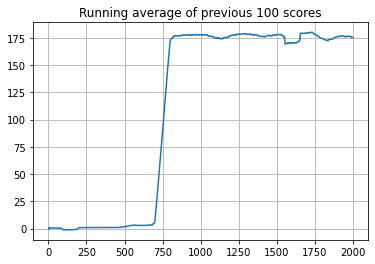

In [34]:
n_episodes = 2000
env_rwd_2 = Maglev()
env_rwd_2.config_reward(optim_exp_dev_rwd)
env_rwd_2.config_reference(generate_const_ref_func(0))

agent_2 = DDPGAgent(obs_shape=env_rwd_2.observation_space.shape[0],
                  n_action=env_rwd_2.action_space.shape[0],
                  lr_actor=1e-4, lr_critic=1e-3,
                  tau=1e-3, gamma=.99,
                  replay_buffer_size=5e4, batch_size=256,
                  uo_theta=.15, uo_sigma=.05,
                  device=device, fc1dim=400, fc2dim=300,
                  critic_l2=1e-4)

coach_2 = Coach(env=env_rwd_2, agent=agent_2, n_episodes=n_episodes, train_limit=(-.5, .5), filename='exponential_deviation_rwd_delta_u')
coach_2.train()

## 4. Resultados
Os resultados foram observados em função da resposta ao degrau em 6 diferentes níveis,  [0.9, 0.5, 0.25, -0.25, -0.5, -0.9]. Destaca-se que os níveis de maior valor absoluto estão fora da faixa de valores de trainamento e demonstram capacidade de generalização.
Para a apresentação dos resultados foi implementada a seguinte classe:



In [35]:
class Results:
  def __init__(self, agent, env):
    self.agent = agent
    self.env = env

  def show_results(self):
    check_values = [.9, .5, .25, -.25, -.5, -.9]
    quad_err = []

    fig, ax = plt.subplots(len(check_values), 1)

    if __name__ == "__main__":
        # in this case the reward function is used to evaluate the results in terms of
        # quadratic error

        self.env.config_reward(quadratic_err)

        # turn off the exploration process
        self.agent.uo_theta = 0
        self.agent.uo_sigma = 0

        for i in range(len(check_values)):
            self.env.config_reference(generate_const_ref_func(check_values[i]))
            obs = self.env.reset()
            game_score = 0
            done = False
            states = []
            actions = []
            rewards = []


            while not done:
                action = self.agent.choose_action(obs)
                next_obs, reward, done, _ = self.env.step(action)

                states.append(obs)
                actions.append(action)
                rewards.append(reward)
                obs = next_obs

            t_ = self.env.time_step * np.arange(min(len(states), self.env.max_steps+1))
            states = np.array(states)

            ax[i].plot(t_, states.T[2, :] ,label='y')
            ax[i].plot(t_, [self.env.reference_function(t_i) for t_i in t_], 'r--', label='ref')
            
            quad_err.append(np.mean(rewards).item())

        ax[0].legend()
        fig.show()
        # print('Quadratic mean err: {} ({})'.format(quad_err, np.mean(quad_err)))
        return quad_err





### 4.1 Resultado na planta estudada

As células a seguir executam os testes das diferentes funções de recompesa.

C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creatin

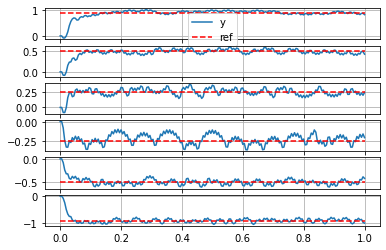

In [36]:
quad_err_1 = Results(agent_1, env_rwd_1).show_results()

C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creatin

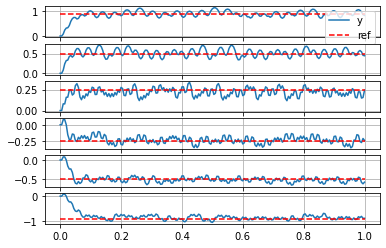

In [37]:
quad_err_2 = Results(agent_2, env_rwd_2).show_results()

Com as duas funções de recompensa observa-se que o controlador consegue ir para os diferentes níveis dos degraus passados como referência. Inclusive para níveis fora da faixa de treino, demonstrando capacidade de generalização. No entanto, há um comportamento oscilatório e irregular no entorno da referência no estado estacionário. As médias dos erros quadráticos médios são:

In [38]:
print("Valores dos erros quadráticos em cada execução um dos diferentes níveis dos testes para primeira função de recompensa: {}\n Média dos erros quadráticos:{}".format(quad_err_1, np.mean(quad_err_1)))

print("Valores dos erros quadráticos em cada execução um dos diferentes níveis dos testes para segunda função de recompensa: {}\n Média dos erros quadráticos:{}".format(quad_err_2, np.mean(quad_err_2)))

Valores dos erros quadráticos em cada execução um dos diferentes níveis dos testes para primeira função de recompensa: [0.027601739145359745, 0.01029341227526541, 0.00431979616914668, 0.005000981173822142, 0.006159939916861975, 0.01517061231788352]
 Média dos erros quadráticos:0.011424413499723245
Valores dos erros quadráticos em cada execução um dos diferentes níveis dos testes para segunda função de recompensa: [0.02483732623191668, 0.011819225459830393, 0.0039587379915282175, 0.004892444763991935, 0.011033750859140877, 0.03630110818523325]
 Média dos erros quadráticos:0.015473765581940226


A análise dos erros quadráticos permite observar que a solução da inserção de um fator punitivo para as ações de controle não se mostrou efetivo. A ponderação atribuída a ele foi obtido por tentativa e erro, no entanto foi observado que valores maiores instabilizavam o aprendizado.

### 4.2 Resultado em uma das plantas originais

A planta original linear SISO do primeiro exemplo apresentado em [1] é representada pela classe PaperMachine implementada na célula a baixo:

In [39]:

class PaperMachine(Env):
    def __init__(self):
        # Based on Spielberg, Steven, et al. “Deep reinforcement learning for process control: A primer for beginners.” arXiv preprint arXiv:2004.05490 (2020).

        self.y_max = 100
        self.u_max = 100
        self.time_step = 0.005
        self.max_steps = 1 / self.time_step
        self.delta_u_limit = 10

        # state with memory implementation like in Spielberg reference
        self.n_memory = 0

        # setup for gym environment framework
        high_act = np.array(
            [self.u_max * 2]
        )
        high_obs = np.array(
            [
                self.y_max * 2,   # ref
                self.y_max * 2,   # y
            ] + self.n_memory * [
                self.y_max,   # y_memory
            ],
            dtype=np.float32
        )

        low_obs = -high_obs

        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
        self.observation_space = spaces.Box(low_obs, high_obs, dtype=np.float32)

        # variables initialization
        self.state = None
        self.previous_u = None
        self.step_counter = None

        self.reference_function = None
        self.reward_function = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        assert self.reference_function is not None, "Define a reference function with config_reference method"
        assert self.reward_function is not None, "Define a reward function with config_reward method"

        # translate and signal conforming
        u = 100 + action*200
        _, y, *memory = self.state

        # dynamic equation
        y = .6 * y + .05 * u

        # memory shift
        if self.n_memory > 0:
            memory = [y] + memory[:-1]

        # get error
        ref = self.reference_function(self.step_counter * self.time_step)
        err = y - ref

        # save state
        self.state = err, y, *memory

        # stopping condition
        terminated = bool(
            np.abs(y) > self.y_max
            or self.step_counter >= self.max_steps
        )

        # reward function
        if not terminated:
            reward = self.reward_function(self.state, action, ref)
        else:
            reward = 0

        self.step_counter += 1
        self.previous_u = u

        return np.array(self.state, dtype=np.float32).squeeze(), reward, terminated, {}

    def reset(self, *,
              seed: Optional[int] = None,
              x0_variance: Optional[float] = 0):
        self.state = (
            self.reference_function(0),
            np.random.uniform(low=-x0_variance * self.y_max, high=x0_variance * self.y_max),
            *(self.n_memory * [0]))
        self.previous_u = 0
        self.step_counter = 0

        return np.array(self.state, dtype=np.float32)

    def render(self, mode=None):
        pass

    def config_reference(self, func):
        self.reference_function = func

    def config_reward(self, func):
        self.reward_function = func


A seguir é realizado o treinamento do agent e os códigos relativos a apresentação dos resultados.

skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping l

C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping learning, not enough transitions...
skipping l

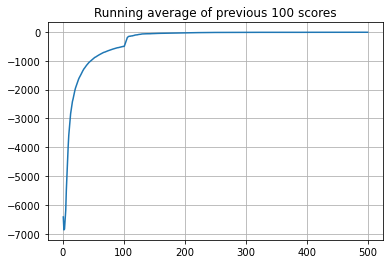

In [40]:
env_pm = PaperMachine()
env_pm.config_reward(neg_abs_err_rwd)
env_pm.config_reference(generate_const_ref_func(0))

agent_pm = DDPGAgent(obs_shape=env_pm.observation_space.shape[0],
                     n_action=env_pm.action_space.shape[0],
                     lr_actor=1e-4, lr_critic=1e-3,
                     tau=1e-3, gamma=.99,
                     replay_buffer_size=5e4, batch_size=256,
                     uo_theta=.15, uo_sigma=.1,
                     device=device, fc1dim=400, fc2dim=300,
                     critic_l2=1e-4)

coach_pm = Coach(env=env_pm, 
                 agent=agent_pm, 
                 n_episodes=500, 
                 train_limit=(0, 10), 
                 filename='paper_machine')
coach_pm.train()


total rwd: -31.00680923461914


C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\gabri\anaconda3\envs\ModernReinforcementLearning\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


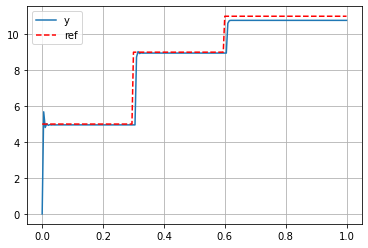

In [41]:
fig, ax = plt.subplots(1)

env_pm.config_reference(multi_step_ref_func)
agent_pm.noise.uo_theta = 0
agent_pm.noise.uo_sigma = 0
obs = env_pm.reset()
game_score = 0
done = False
states = []
actions = []
rewards = []

while not done:
    action = agent_pm.choose_action(obs)
    next_obs, reward, done, _ = env_pm.step(action)

    states.append(obs)
    actions.append(action)
    rewards.append(reward)
    obs = next_obs

t_ = env_pm.time_step * np.arange(min(len(states), env_pm.max_steps + 1))
states = np.array(states)

ax.plot(t_, states.T[1, :], label='y')
ax.plot(t_, [env_pm.reference_function(t_i) for t_i in t_], 'r--', label='ref')
print('total rwd: {}'.format(np.cumsum(rewards)[-1].item()))
ax.legend()
fig.show()

## 5. Conclusão

As funções de recompensa apresentadas em [1] não tratam bem problemas instáveis. A instabilidade do sistema somada a recompensas puramente punitivas acaba promovendo comportamentos instabilizantes do agente que passa a buscar o encurtamento máximo dos episódios. Nesse sentido, foram estudadas outras funções de recompensas capazes de contornar este aspecto e as funções propostas foram capazes de estabilizar o problema e levar a variável controlada a referência. No entanto, no estado estacionário a variável controlada apresenta-se ruidosa tornando o controle estudado pouco adequado. O mapeamento das funções de recompensa e os resultados finais ainda é assunto de pesquisa em aberto.
O presente trabalho apresentou uma abordagem inicial. Um estudo mais detalhado da variação dos hiperparâmetros se faz necessário. Destaca-se que a diferença de complexidade das plantas apresentadas no artigo original e a tratada é grande. Isso pode implicar necessidade de redes mais complexas para endereçar problemas como os apresentados. Isto recaí na necessidade de maior exploração do espaço dos hiperparâmetros associados ao método em estudo, que não foi viável no tempo disponível para o trabalho podendo ser assunto para trabalhos futuros.


Referências

[1]: Spielberg, Steven, et al. "Deep reinforcement learning for process control: A primer for beginners." arXiv preprint arXiv:2004.05490 (2020).

[2]: Dally, K., & Van Kampen, E. J. (2022). Soft Actor-Critic Deep Reinforcement Learning for Fault Tolerant Flight Control. In AIAA SCITECH 2022 Forum (p. 2078).

[3]: Bucci, Michele Alessandro, et al. "Control of chaotic systems by deep reinforcement learning." Proceedings of the Royal Society A 475.2231 (2019): 20190351.

[4]: Galvão, R.K.H., Yoneyama, T., Araújo, F.M.U. and Machado, R.G., 2003, "A simple technique for identifying a linearized model for a didactic magnetic levitation system" IEEE Transactions on Education, Vol. 46, No. 1, pp. 22-25.

[5]: Fama, Régis Campos, et al. "Predictive control of a magnetic levitation system with explicit treatment of operational constraints." Proceedings of the 18th International Congress of Mechanical Engineering, Ouro Preto, Brazil. 2005.

[6]: Lillicrap, Timothy P., et al. "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971 (2015).

[7]: Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." Nature 518.7540 (2015): 529-533

[8]: Hausknecht, Matthew, and Peter Stone. "Deep reinforcement learning in parameterized action space." arXiv preprint arXiv:1511.04143 (2015).

[9]: Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, (2018).

[10]: Lapan, Maxim. Deep Reinforcement Learning Hands-On: Apply modern RL methods to practical problems of chatbots, robotics, discrete optimization, web automation, and more. Packt Publishing Ltd, 2020.

[11]: Tabor, Phil. Actor Critic Methods Paper to Code. https://github.com/philtabor/Actor-Critic-Methods-Paper-To-Code, 2020.




